# Inverse transform sampling

Inverse transform sampling is a method for drawing samples from a distribution for which a certain "inverse transform function" can be analytically derived. This allows us to draw samples very efficiently from such a function.

Let us first derive what an inverse transform function is. Consider a univariate random variable $X$ whose probability density function (PDF) is $f_X(x)$ in an interval $[a, b]$. Its cumulative distribution function (CDF) is given by

$F_X(x) := P[X\le x] = \int_a^b f_X(x) dx\,.$

The inverse transform of $f_X$ is a function $T$ such that the PDF of $T(U)$ is $f_X$ if $U$ univariate random variable drawn uniformly from $[0,1]$. 

The function $T$ can be determined as follows. We assume that $T: [0,1] \rightarrow [a,b]$ is an increasing function. Then,

$F_X[x] = P[X\le x] = P[T(U) \le x] = P[U \le T^{-1}(x)] = T^{-1}(x)$

In the last step, we used the fact that the CDF of the uniform distribution is the identity function. 

i.e., the inverse transform function is the inverse of the CDF.

For example, consider the PDF

$f_{X}(x)=\frac{1}{2}\begin{cases}
0 & x<0\\
1 & 0\le x\le1\\
\exp(1-x) & x>1
\end{cases}$

Its CDF is

$F_{X}(x)=\frac{1}{2}\begin{cases}
0 & x<0\\
x & 0\le x\le1\\
2-\exp(1-x) & x>1
\end{cases}$

and its inverse transform function is

$T(u)=\begin{cases}
2x & 0\le u\le1/2\\
1-\ln(2-2u) & u>1/2
\end{cases}$

Now let us try plotting this.

In [1]:
import numpy as np

def pdf(x):
    return 0.5 * np.heaviside(x, 0) * (np.heaviside(1-x, 1)  + np.heaviside(x-1, 0) * np.exp(1-x))

def cdf(x):
    return 0.5 * np.heaviside(x, 0) * (x*np.heaviside(1-x, 1)  + np.heaviside(x-1, 0) * (2 - np.exp(1-x)))

def invtran(u):
    return (2*u*np.heaviside(1/2-u, 1)  + np.heaviside(u-1/2, 0) * (1 - np.log(2-2*u)))

/tmp/ipykernel_141885/641795444.py:10: RuntimeWarning: divide by zero encountered in log
  return (2*u*np.heaviside(1/2-u, 1)  + np.heaviside(u-1/2, 0) * (1 - np.log(2-2*u)))


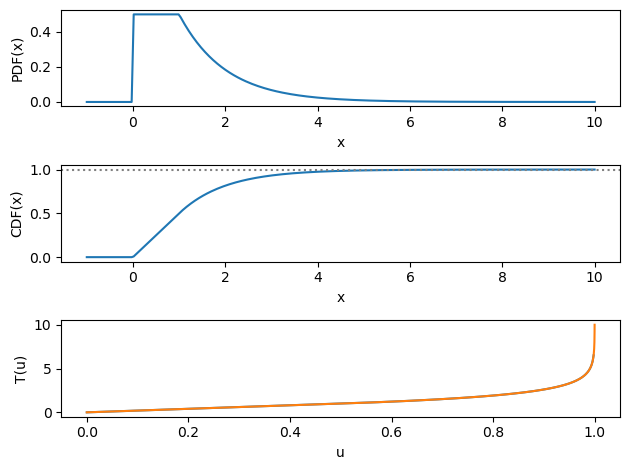

In [2]:
import matplotlib.pyplot as plt

plt.subplot(311)
x = np.linspace(-1, 10, 250)
plt.plot(x, pdf(x))
plt.xlabel("x")
plt.ylabel("PDF(x)")

plt.subplot(312)
plt.plot(x, cdf(x))
plt.axhline(1, color="grey", ls="dotted")
plt.xlabel("x")
plt.ylabel("CDF(x)")

plt.subplot(313)
u = np.linspace(0, 1, 500)
plt.plot(u, invtran(u))
x = np.linspace(0, 10, 250)
plt.plot(cdf(x), x)
# plt.axhline(1, color="grey", ls="dotted")
plt.xlabel("u")
plt.ylabel("T(u)")

plt.tight_layout()

Let us sample this distribution.

In [3]:
U = np.random.rand(50000)
X = invtran(U)

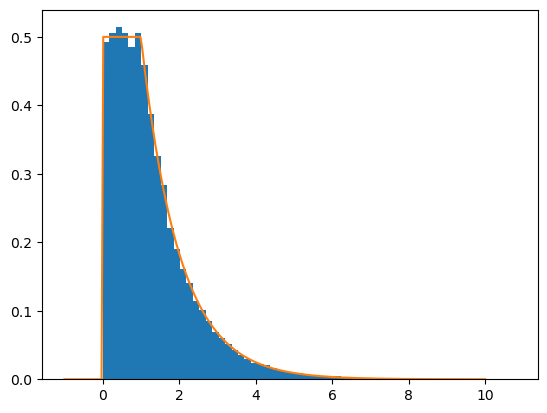

In [4]:
plt.hist(X, bins=64, density=True)
x = np.linspace(-1, 10, 250)
plt.plot(x, pdf(x))

# It works!

If a multivariate distribution can be factorized into a product of univariate distributions, then inverse transform sampling can be applied to each dimension separately.

Now let us try a more complicated 2D example.

The advantage of this method is that (1) it is fast because drawing samples from the uniform distribution is easy and because the inverse transform function is analytic, and (2) the samples are uncorrelated.

The disadvantage is that it can only be applied to simple distributions with analytic inverse transforms, and most distributions in the real world are not analytically tractable.

## 2D example

Consider the following unnormalized PDF:

$f'(x,y) = \exp[-(\sqrt{x^2+y^2}-5)^2]$

We can find the normalization constant analytically using polar coordinates.

$C = \int_{-\infty}^{\infty} dx \int_{-\infty}^{\infty} dy \exp[-(\sqrt{x^2+y^2}-5)^2] = \int_{-\pi}^{\pi} d\theta \int_{0}^{\infty} r dr  \exp[-(r-5)^2] = 5 \pi^{3/2} (1+\text{GammaRegularizedP[-0.5,25]}) \approx 55.6833$

In [5]:
C = 55.68327996831789

The inverse transform of this function can be written as follows.

The PDF in polar coordinates is

$f(r,\theta) = \frac{1}{C}  r \exp[-(\sqrt{x^2+y^2}-5)^2]$ with $-\pi<\theta\le \pi$ and $r>0$.

Clearly,

$f(\theta) = \text{Uniform}[-\pi, ~\pi; \theta]$

and

$f(r) = \frac{2\pi}{C} r \exp[-(r-5)^2] \Theta[r]$

The CDFs are

$F(\theta) = (r+\pi)/2\pi$  with $-\pi<\theta\le \pi$

$F(r) = \frac {\pi\left (-5\sqrt {\pi}\text{erf} (5 - \rho) +       5\sqrt {\pi}\text{erf} (5) -       e^{-(\rho - 5)^2} + {e^{-25}} \right)} {C}$

The inverse transform for $\theta$ is

$T_\theta(u) = 2\pi u - \pi$

Unfortunately, obtaining the inverse transform for $r$ analytically isn't easy. We can try to do this numerically.

The PDF looks like this:

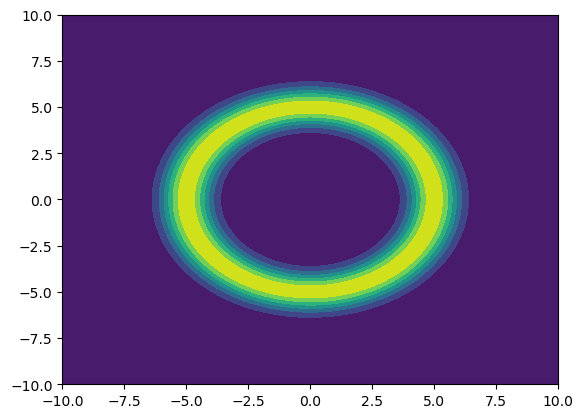

In [6]:
def log_f1(params):
    x, y = params
    u = np.sqrt(x*x + y*y)
    return -(u-5)**2 

x, y = np.meshgrid(np.linspace(-10, 10, 5000), np.linspace(-10, 10, 5000))
z = log_f1((x, y))
plt.contourf(x, y, np.exp(z))

In [7]:
from scipy.special import erf

def cdf_r(r):
    C = 55.68327996831789
    return (np.pi*(np.exp(-25) - np.exp(-(-5 + r)**2) + 5*np.sqrt(np.pi)*erf(5) - 5*np.sqrt(np.pi)*erf(5 - r)))/C

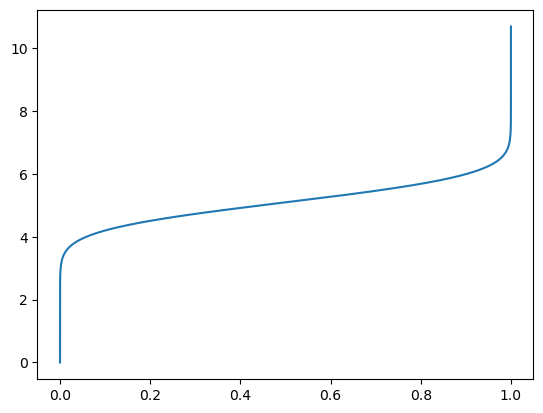

In [8]:
rs = np.linspace(0, 10.7, 500)
plt.plot(cdf_r(rs), rs)

In [9]:
max(cdf_r(rs))

0.9999999999999992

In [10]:
from scipy.interpolate import CubicSpline

invtran_spl = CubicSpline(cdf_r(rs), rs)

umax = max(cdf_r(rs))
rmax = max(rs)

def invtran_1(cube):
    u, v = cube
    theta = np.pi*(2*v-1)
    if u <= umax:
        r = invtran_spl(u)
    else:
        r = rmax + (1000-rmax)*(u-umax)/(1-umax)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return (x, y)

In [13]:
samples = np.array([invtran_1(cube) for cube in np.random.rand(10000, 2)])

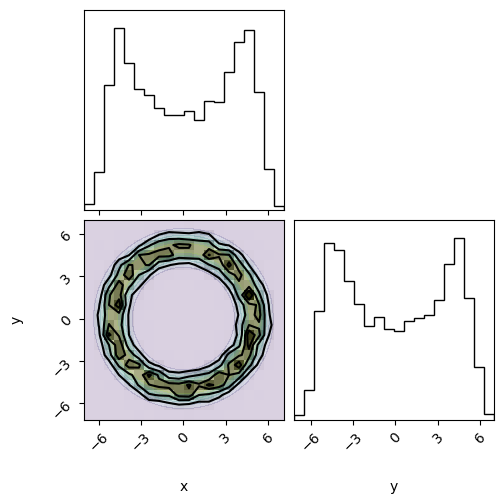

In [14]:
import corner

fig = corner.corner(samples, labels=["x", "y"], plot_datapoints=False)

plt.subplot(223)
plt.contourf(x, y, np.exp(z), alpha=0.2)